In this notebook the performance of the **simple** NDVI prediction time series are summarized.
- Used dataset: It was downloaded and processed by Ondrej from ASAP, and is located in the google drive.
    - The dataset contains 10-day information (unlike what we have from GEE and IPAR). The goal is to see the feasability with a ready-to-go dataset that scans many years. 
    - Data: https://drive.google.com/drive/folders/1hRS1mx2YES-nbCCn9OFmciSQhorHeAds?usp=sharing
    - Notebook: https://github.com/OmdenaAI/GPSDD-Food-Security-Senegal/blob/main/notebooks/task_1_climate-risk/ASAP_data_1.ipynb
- There are 4 models that are obtained using SARIMA(X)
    - Fitting notebooks: asap_ndvi_time_series_years.ipynb, asap_ndvi_time_series_next_weeks.ipynb
    - Since these are simple models, they are trained only to predict the NDVI in a single region (Kaffrine) as a feasability study
    - Model 'trained' on 2002-2013 data with the aim to predict the NDVI for the full year - 2014 
        - Prediction of NDVI based on solely past NDVI data (SARIMA). Optimized scanning large set of variables. 
        - Prediction of NDVI based on past NDVI data and rainfall as the exogenous term. Optimized using subset of variables based on the above. 
        - Fitting notebook: asap_ndvi_time_series_years
    - Model 'trained' on 2002-2013 data + 2014 data (including) up to June, with the aim to predict the NDVI for the rest of the critical growing season (July, August, September) within the current year
        - Prediction of NDVI based on solely past NDVI data (SARIMA). Optimized scanning large set of variables. 
        - Prediction of NDVI based on past NDVI data and rainfall as the exogenous term. Optimized using subset of variables based on the above. 
        - Fitting notebooks: asap_ndvi_time_series_next_weeks.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import datetime as dt

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from itertools import product

import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# Metrics from sklearn
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

#from tqdm import tqdm_notebook
#from itertools import product
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
asap_file_path = '../../data/external/SEN_asap_region.csv'

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

In [3]:
asap_file = pd.read_csv(asap_file_path, parse_dates=['date'])
asap_file.head(10)

,Unnamed: 0,region_name,variable_name,sensor_name,class_name,date,value,year,month,day,yearday
0,0,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-01-01,25.302,1989,1,1,1
1,1,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-01-11,26.047,1989,1,11,11
2,2,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-05-01,31.429,1989,5,1,121
3,3,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-05-11,32.047,1989,5,11,131
4,4,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-05-21,32.364,1989,5,21,141
5,5,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-06-01,31.287,1989,6,1,152
6,6,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-06-11,28.216,1989,6,11,162
7,7,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-06-21,27.000,1989,6,21,172
8,8,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-07-01,26.000,1989,7,1,182
9,9,Kolda,Temperature,ECMWF,Rangeland during growing cycle,1989-07-11,26.000,1989,7,11,192


Get the training, validation datasets for Kaffrine. Get both options: yearly and weekly split 

In [4]:
# Useful functions
def are_dates_unique(df):
    if(len(df["date"].unique())== df.shape[0]):
        return True
    else:
        return False
    
def date_as_index(df):
    if are_dates_unique(df):
        df = df.set_index('date')
        df.sort_index(inplace=True)
        return df
    else:
        warnings.warn('Dates are not unique, could not set them as indices')
        return df
    
# For now keeping some additional info as class_name, region_name etc although they will be specific
def region_class_value_specific_df(df, cl, region, wanted_columns = ["class_name","region_name", "variable_name", "date", "value"]):
    selected_subset_df = df.loc[(df["class_name"] == cl) &  (df["region_name"] == region), wanted_columns]
    df_ndvi = selected_subset_df.loc[(df["variable_name"] == "NDVI")]
    df_temperature = selected_subset_df.loc[(df["variable_name"] == "Temperature")]
    df_rainfall = selected_subset_df.loc[(df["variable_name"] == "Rainfall")]
    # use dates as indices (if they are unique)
    df_ndvi = date_as_index(df_ndvi)
    df_temperature = date_as_index(df_temperature)
    df_rainfall = date_as_index(df_rainfall)
    
    earliest_date_ndvi = min(df_ndvi.index)
    earliest_date_temperature = min(df_temperature.index)
    earliest_date_rainfall = min(df_rainfall.index)
    earliest_date = max([earliest_date_ndvi, earliest_date_temperature, earliest_date_rainfall])
    print("Earliest date: {}".format(earliest_date))

    last_date_ndvi = max(df_ndvi.index)
    last_date_temperature = max(df_temperature.index)
    last_date_rainfall = max(df_rainfall.index)
    last_date = min([last_date_ndvi, last_date_temperature, last_date_rainfall])
    print("Latest date: {}".format(last_date))
    return df_ndvi, df_temperature, df_rainfall

# Split into training, validation, test by year
# Training: 2002-2013
# With 10 day intervals, this will mean making 36 new predictions (for whole year, next year)
# Validation: 2014 # For now, want to keep 2014 here to have the chance to use/test with the IPAR data, maybe
# Test: 2015
def split_training_validation_test_by_year(df, min_training='2002', max_training='2013', validation='2014', test='2015'):
    training_data = df.loc[min_training:max_training]
    validation_data = df.loc[validation]
    test_data = df.loc[test]
    return training_data,validation_data, test_data

# Another option: Few weeks after the planting, predict the NDVI during the growing/critical season... 
# Data given up to june, predict july? 
# Here need to know about the planting, growing seasons and is dependent on the crop, maybe nicer with DNN 
def split_training_validation_test_by_date(df, min_training='2002-01', max_training='2014-06', min_validation='2014-07', max_validation='2014-09'):
    training_data = df.loc[min_training:max_training]
    validation_data = df.loc[min_validation:max_validation]
    return training_data, validation_data    

In [5]:
# Frist get the Kaffrine, crop dataset
crop_Kaffrine_ndvi, crop_Kaffrine_temperature, crop_Kaffrine_rainfall = region_class_value_specific_df(df = asap_file, cl = "Crop", region = "Kaffrine")

Earliest date: 2001-10-01 00:00:00
Latest date: 2020-11-21 00:00:00


In [6]:
# Datasets split by years to make a prediction for the next year
years_train_crop_ndvi, years_val_crop_ndvi, years_test_crop_ndvi = split_training_validation_test_by_year(crop_Kaffrine_ndvi)
years_train_crop_temperature, years_val_crop_temperature, years_test_crop_temperature = split_training_validation_test_by_year(crop_Kaffrine_temperature)
years_train_crop_rainfall, years_val_crop_rainfall, years_test_crop_rainfall = split_training_validation_test_by_year(crop_Kaffrine_rainfall)

In [7]:
# Datasets split by years + weeks into the validation year to make a prediction for the next monhts
weeks_train_crop_ndvi, weeks_val_crop_ndvi = split_training_validation_test_by_date(crop_Kaffrine_ndvi)
weeks_train_crop_rainfall, weeks_val_crop_rainfall = split_training_validation_test_by_date(crop_Kaffrine_rainfall)

Start studying the predictions

In [8]:
# For auto arima 
import pmdarima as pm

# For serialization:
import joblib
import pickle

In [9]:
# Load all the saved models
with open('smodel_sarima_kaffrine.pkl', 'rb') as pkl:
    years_smodel_arima_kaffrine = pickle.load(pkl)
   
with open('smodel_x_sarima_kaffrine.pkl', 'rb') as pkl:
    years_smodel_x_arima_kaffrine = pickle.load(pkl)

with open('smodel_sarima_kaffrine_next_weeks.pkl', 'rb') as pkl:
    weeks_smodel_arima_kaffrine = pickle.load(pkl)

# To add: weeks with exo when done
with open('smodel_x_sarima_kaffrine_next_weeks.pkl', 'rb') as pkl:
    weeks_smodel_x_arima_kaffrine = pickle.load(pkl)

In [10]:
# Get the predictions and compare with the actual values

# To get the predictions
def get_predictions_sarima(model, validation_data):
    forecasted = model.predict(n_periods=(validation_data.shape[0]))
    forecasted_series = pd.Series(forecasted, index=validation_data.index)
    return forecasted_series
    
# exo_data = years_val_crop_rainfall[["value"]]    
def get_predictions_sarimax(model, validation_data, exo_data):
    forecasted = model.predict(n_periods=(validation_data.shape[0]), exogenous=exo_data)  
    forecasted_series = pd.Series(forecasted, index=validation_data.index)
    return forecasted_series

In [11]:
####################################

# Model trained on 2002-2013 data
# Aim to predict the NDVI for the full year - 2014 (36 points)

# Using only past NDVI values
years_smodel_arima_kaffrine_forecasted_series = get_predictions_sarima(years_smodel_arima_kaffrine, years_val_crop_ndvi)
# Using past NDVI values and rainfall as the exogenous data
years_smodel_x_arima_kaffrine_forecasted_series = get_predictions_sarimax(years_smodel_x_arima_kaffrine, years_val_crop_ndvi, years_val_crop_rainfall[["value"]])

####################################

# Model trained on 2002-2013 data + 2014 data (including) up to June
# Aim to predict the NDVI for the rest of the critical growing season (July, August, September) 

# Using only past NDVI values
weeks_smodel_arima_kaffrine_forecasted_series = get_predictions_sarima(weeks_smodel_arima_kaffrine, weeks_val_crop_ndvi)
# Using past NDVI values and rainfall as the exogenous data
weeks_smodel_x_arima_kaffrine_forecasted_series = get_predictions_sarimax(weeks_smodel_x_arima_kaffrine, weeks_val_crop_ndvi, weeks_val_crop_rainfall[["value"]])

/Users/eakilli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/eakilli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [12]:
# Visualise and compare in plots
# Calculate some metrics and write them on/near the figures for ease? 

# Compare the peak values only, since that seems very important for yield:
def absolute_percentage_error_peak(y_true, y_pred):
    return np.abs(max(y_true) - max(y_pred))/max(y_true) * 100    

def plot_training_validation_forecast(train_crop_ndvi, model_predicted_series, val_crop_ndvi_value, which_model='Year, NDVI only'):
 
    mape = mean_absolute_percentage_error(val_crop_ndvi_value, model_predicted_series)
    mae =  mean_absolute_error(val_crop_ndvi_value, model_predicted_series)
    pvabe = absolute_percentage_error_peak(val_crop_ndvi_value, model_predicted_series)  
    
    fig = plt.figure(figsize=(24,12))
    fig.suptitle("SARIMA(X) - Forecast for model: {0}".format(which_model), fontsize=25)
    plt.subplot(1, 2, 1)
    plt.plot(train_crop_ndvi.value, label = 'Training data')
    plt.plot(model_predicted_series, color='darkgreen', label = 'Forecast')
    plt.plot(val_crop_ndvi_value, color = 'black', label = 'Validation data')
    plt.legend(loc='best')
    plt.grid('True')
    plt.title("Training and forecast period")
    plt.subplot(1, 2, 2)
    plt.plot(model_predicted_series, color='darkgreen', label = 'Forecast')
    plt.plot(val_crop_ndvi_value, color = 'black', label = 'Validation data')
    plt.legend(loc='best')
    plt.grid('True')
    plt.title("Forecast period. Mean abs percent error: {mape:.2f}, Mean abs error: {mae:.3f}:, Peak val abs per error: {pvabe:.2f}".format(mape=mape, mae=mae, pvabe=pvabe), fontsize=14)
    
    plt.show()

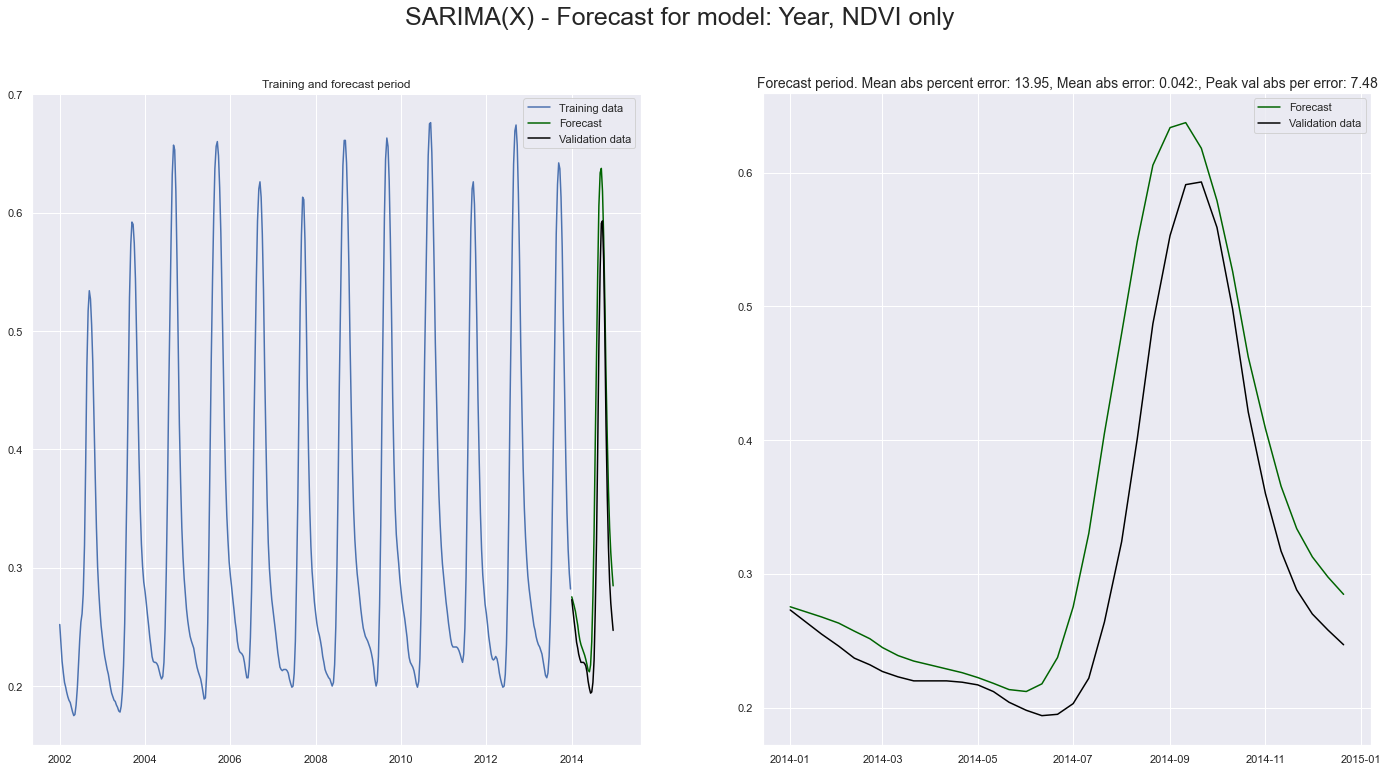

In [13]:
# First plot all these... 
plot_training_validation_forecast(years_train_crop_ndvi, years_smodel_arima_kaffrine_forecasted_series, years_val_crop_ndvi.value, which_model='Year, NDVI only')

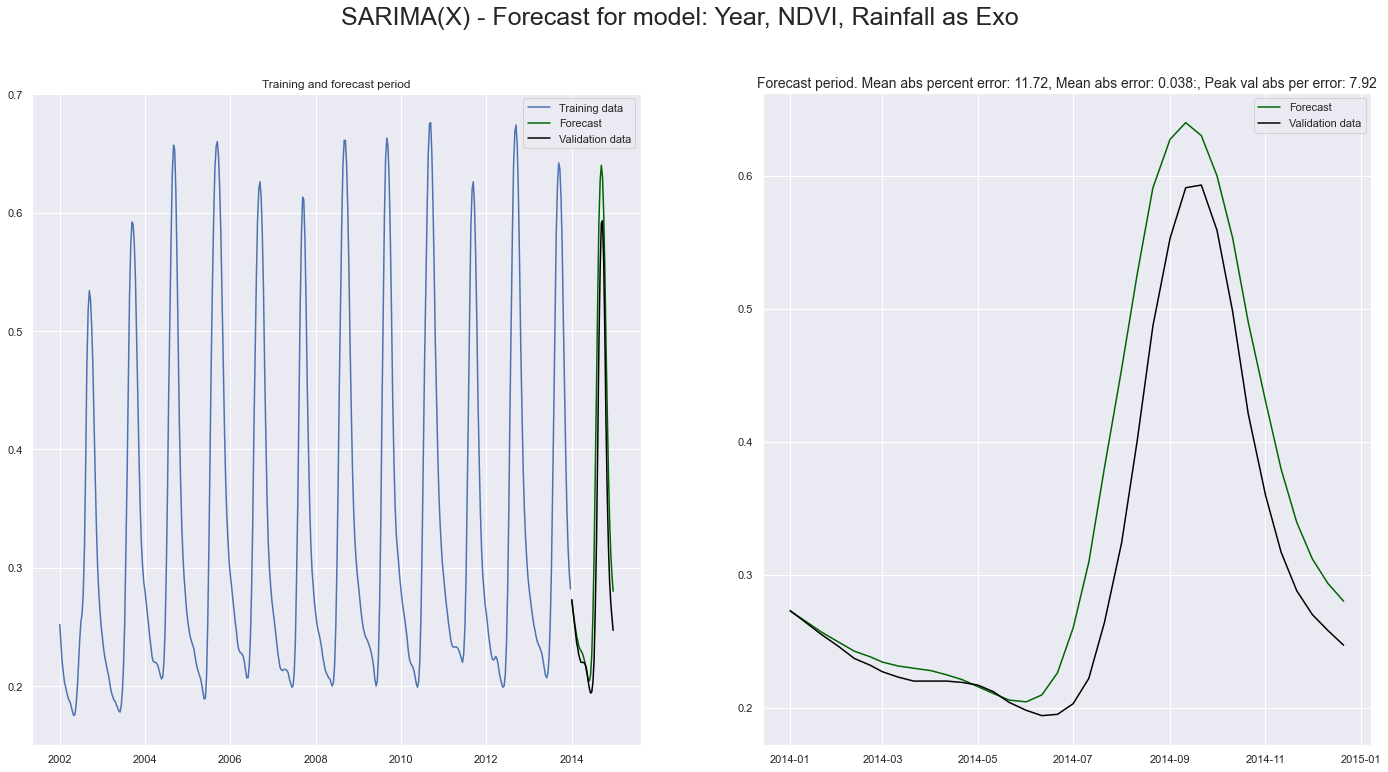

In [14]:
plot_training_validation_forecast(years_train_crop_ndvi, years_smodel_x_arima_kaffrine_forecasted_series, years_val_crop_ndvi.value, which_model='Year, NDVI, Rainfall as Exo')

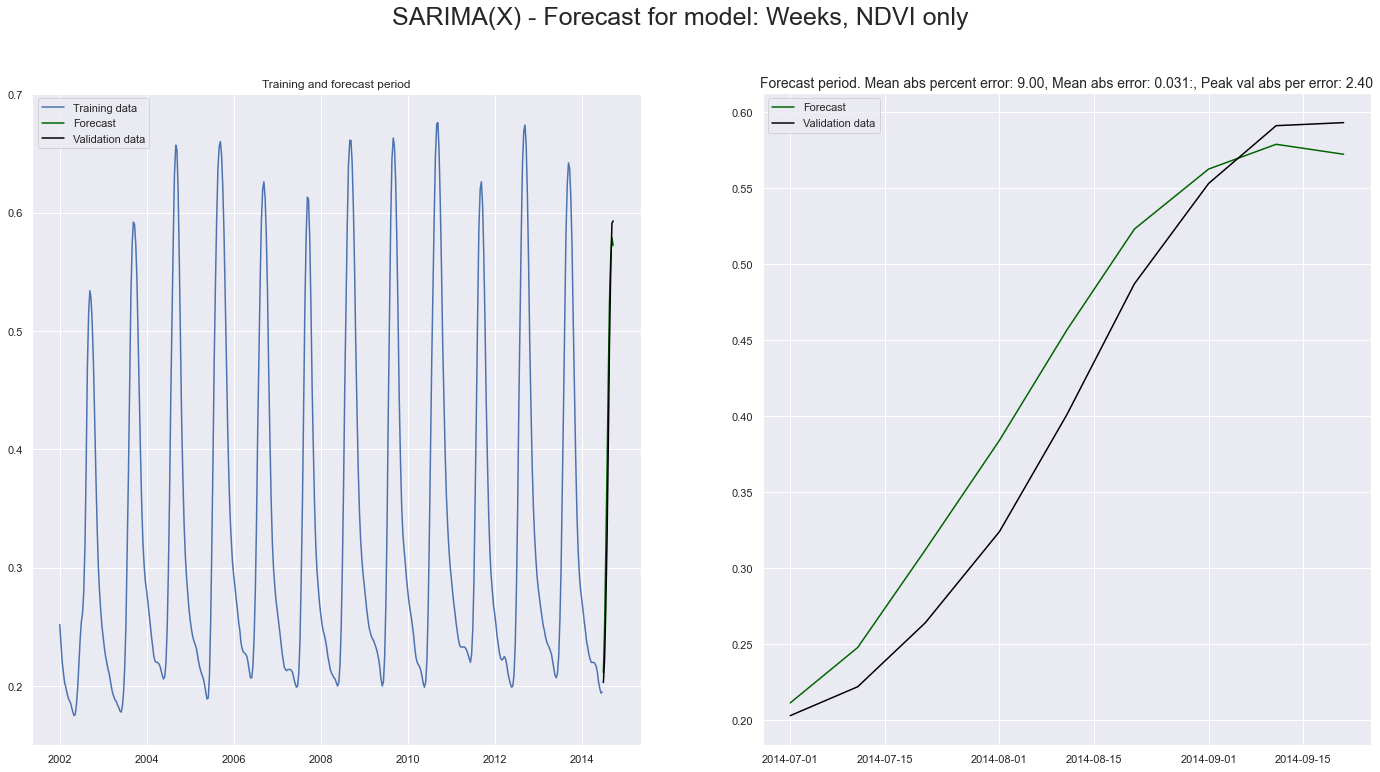

In [15]:
plot_training_validation_forecast(weeks_train_crop_ndvi, weeks_smodel_arima_kaffrine_forecasted_series, weeks_val_crop_ndvi.value, which_model='Weeks, NDVI only')

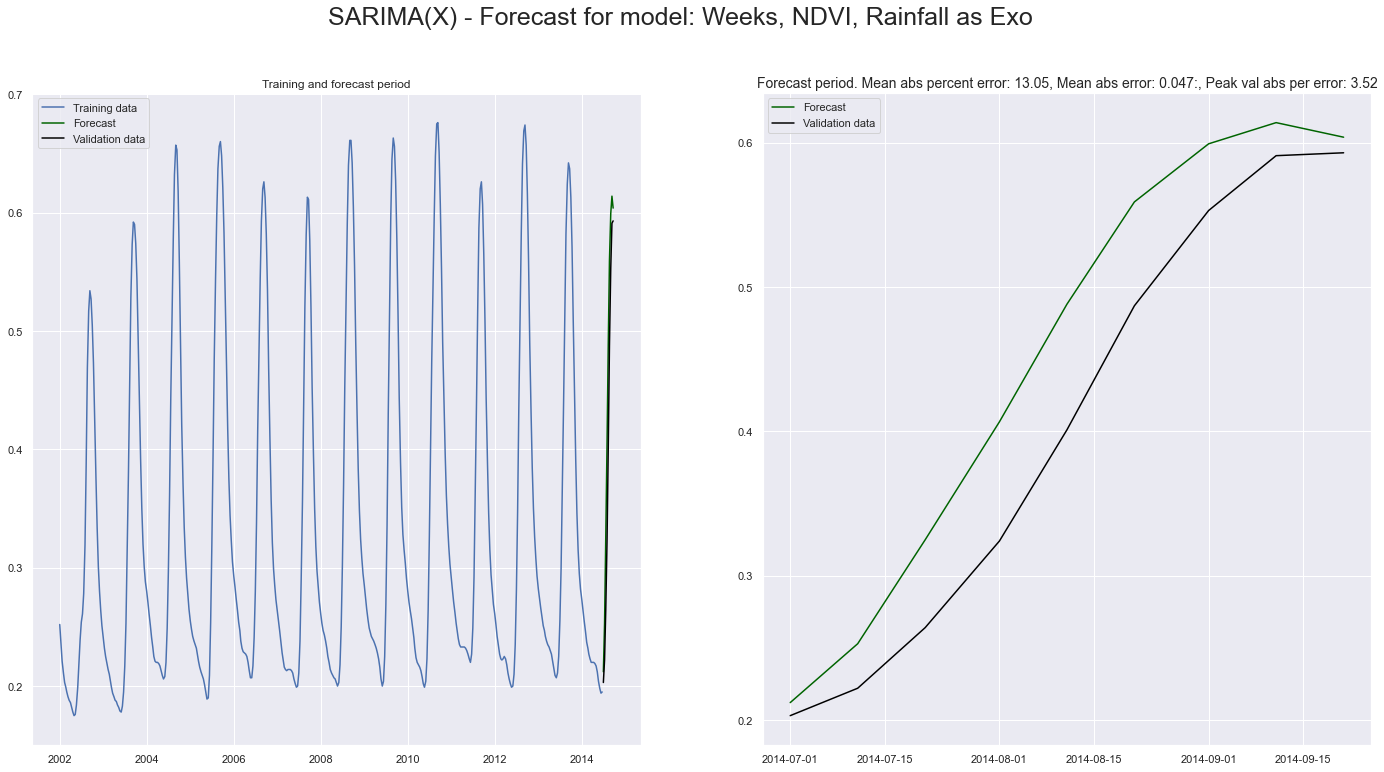

In [16]:
plot_training_validation_forecast(weeks_train_crop_ndvi, weeks_smodel_x_arima_kaffrine_forecasted_series, weeks_val_crop_ndvi.value, which_model='Weeks, NDVI, Rainfall as Exo')


It is weird that the error increased with the addition of the rainfall as exo. variable.
But the shape seems to be better quite closer actually. 

Questions/next steps:
- It would be good to:
    - compare these predicted values with the average of the all years
    - look at the overall deviation between years
    - see how the yield prediction is affected by ~10% difference, and which metric is more relevant
        - Note: in the paper where they do yield calibration by NDVI, they actually are interested in the peak value of the fitted curve. That's why I think getting the peak value right is important
- Do we really need to do this seperately for each single region if we are usig simple models such as SARIMA(X)? 
- Compare the performance of these with a simple (D)NN time series, I think we can do better with less computation power
- Could extend the training set to cover more years and check the performance on the last years if we focus on the regional NDVI and yield (we don't have yield info after 2019) 
- We could use only the growing season data, since that's what matter for the crop but these simple methods do not work (I think) if we don't have a time series that's evenly spaced in time. At the same time maybe the history of NDVI and rainfall prior to the season might also have implications even if small? 